In [10]:
# Building ML settings
# %cd /content/drive/MyDrive/Colab otebooks/class/project
# %pwd
!pip install matminer seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Set universal theme for figures
plt.style.use('seaborn-v0_8')
# Configure plot settings
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.grid'] = True
# Set numerical precision
np.set_printoptions(precision=5)

In [1]:
!pip install pymatgen matminer torch_geometric torch_scatter torch_sparse torch_cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 22.7 MB/s eta 0:00:00
   

In [2]:
from matminer.datasets import load_dataset
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split

# データ取得
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values

# 学習/テスト分割
struct_train, struct_test, y_train, y_test = train_test_split(structures, targets, test_size=0.2, random_state=42)


Fetching castelli_perovskites.json.gz from https://ndownloader.figshare.com/files/13284197 to /usr/local/lib/python3.11/dist-packages/matminer/datasets/castelli_perovskites.json.gz


Fetching https://ndownloader.figshare.com/files/13284197 in MB: 4.9479679999999995MB [00:00, 449.01MB/s]               


In [3]:
import torch
from torch_geometric.data import Data

def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor([site.coords for site in structure], dtype=torch.float)
    atomic_numbers = torch.tensor([site.specie.number for site in structure], dtype=torch.long)

    edge_index = []
    for i, site_i in enumerate(structure):
        for j, site_j in enumerate(structure):
            if i != j and site_i.distance(site_j) < cutoff:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=atomic_numbers.unsqueeze(1), pos=positions, edge_index=edge_index)

# グラフ変換
train_graphs = [structure_to_graph(s) for s in struct_train]
test_graphs = [structure_to_graph(s) for s in struct_test]

# ターゲット追加
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([y_train[i]], dtype=torch.float)


<ipython-input-3-1d85c8e06d63>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  positions = torch.tensor([site.coords for site in structure], dtype=torch.float)


In [4]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32)

model.train()
for epoch in range(1, 21):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = F.l1_loss(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, MAE: {total_loss / len(train_loader):.4f}")


Epoch 1, MAE: 0.1056
Epoch 2, MAE: 0.0988
Epoch 3, MAE: 0.0928
Epoch 4, MAE: 0.0912
Epoch 5, MAE: 0.0890
Epoch 6, MAE: 0.0863
Epoch 7, MAE: 0.0846
Epoch 8, MAE: 0.0842
Epoch 9, MAE: 0.0821
Epoch 10, MAE: 0.0819
Epoch 11, MAE: 0.0826
Epoch 12, MAE: 0.0797
Epoch 13, MAE: 0.0784
Epoch 14, MAE: 0.0772
Epoch 15, MAE: 0.0796
Epoch 16, MAE: 0.0770
Epoch 17, MAE: 0.0772
Epoch 18, MAE: 0.0765
Epoch 19, MAE: 0.0751
Epoch 20, MAE: 0.0762


In [7]:
for i, g in enumerate(test_graphs):
    g.y = torch.tensor([y_test[i]], dtype=torch.float)

In [8]:
test_loader = DataLoader(test_graphs, batch_size=32)
model.eval()
errors = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        errors += torch.abs(out.view(-1) - batch.y.view(-1)).tolist()

print(f"Test MAE: {sum(errors) / len(errors):.4f} eV")


Test MAE: 0.0768 eV



Fold 1
Fold 1 - MAE: 0.083, R²: -0.029

Fold 2
Fold 2 - MAE: 0.088, R²: -0.018

Fold 3
Fold 3 - MAE: 0.060, R²: -0.017

Fold 4
Fold 4 - MAE: 0.079, R²: -0.026

Fold 5
Fold 5 - MAE: 0.078, R²: -0.025

Average MAE: 0.078 ± 0.010
Average R²: -0.023 ± 0.005


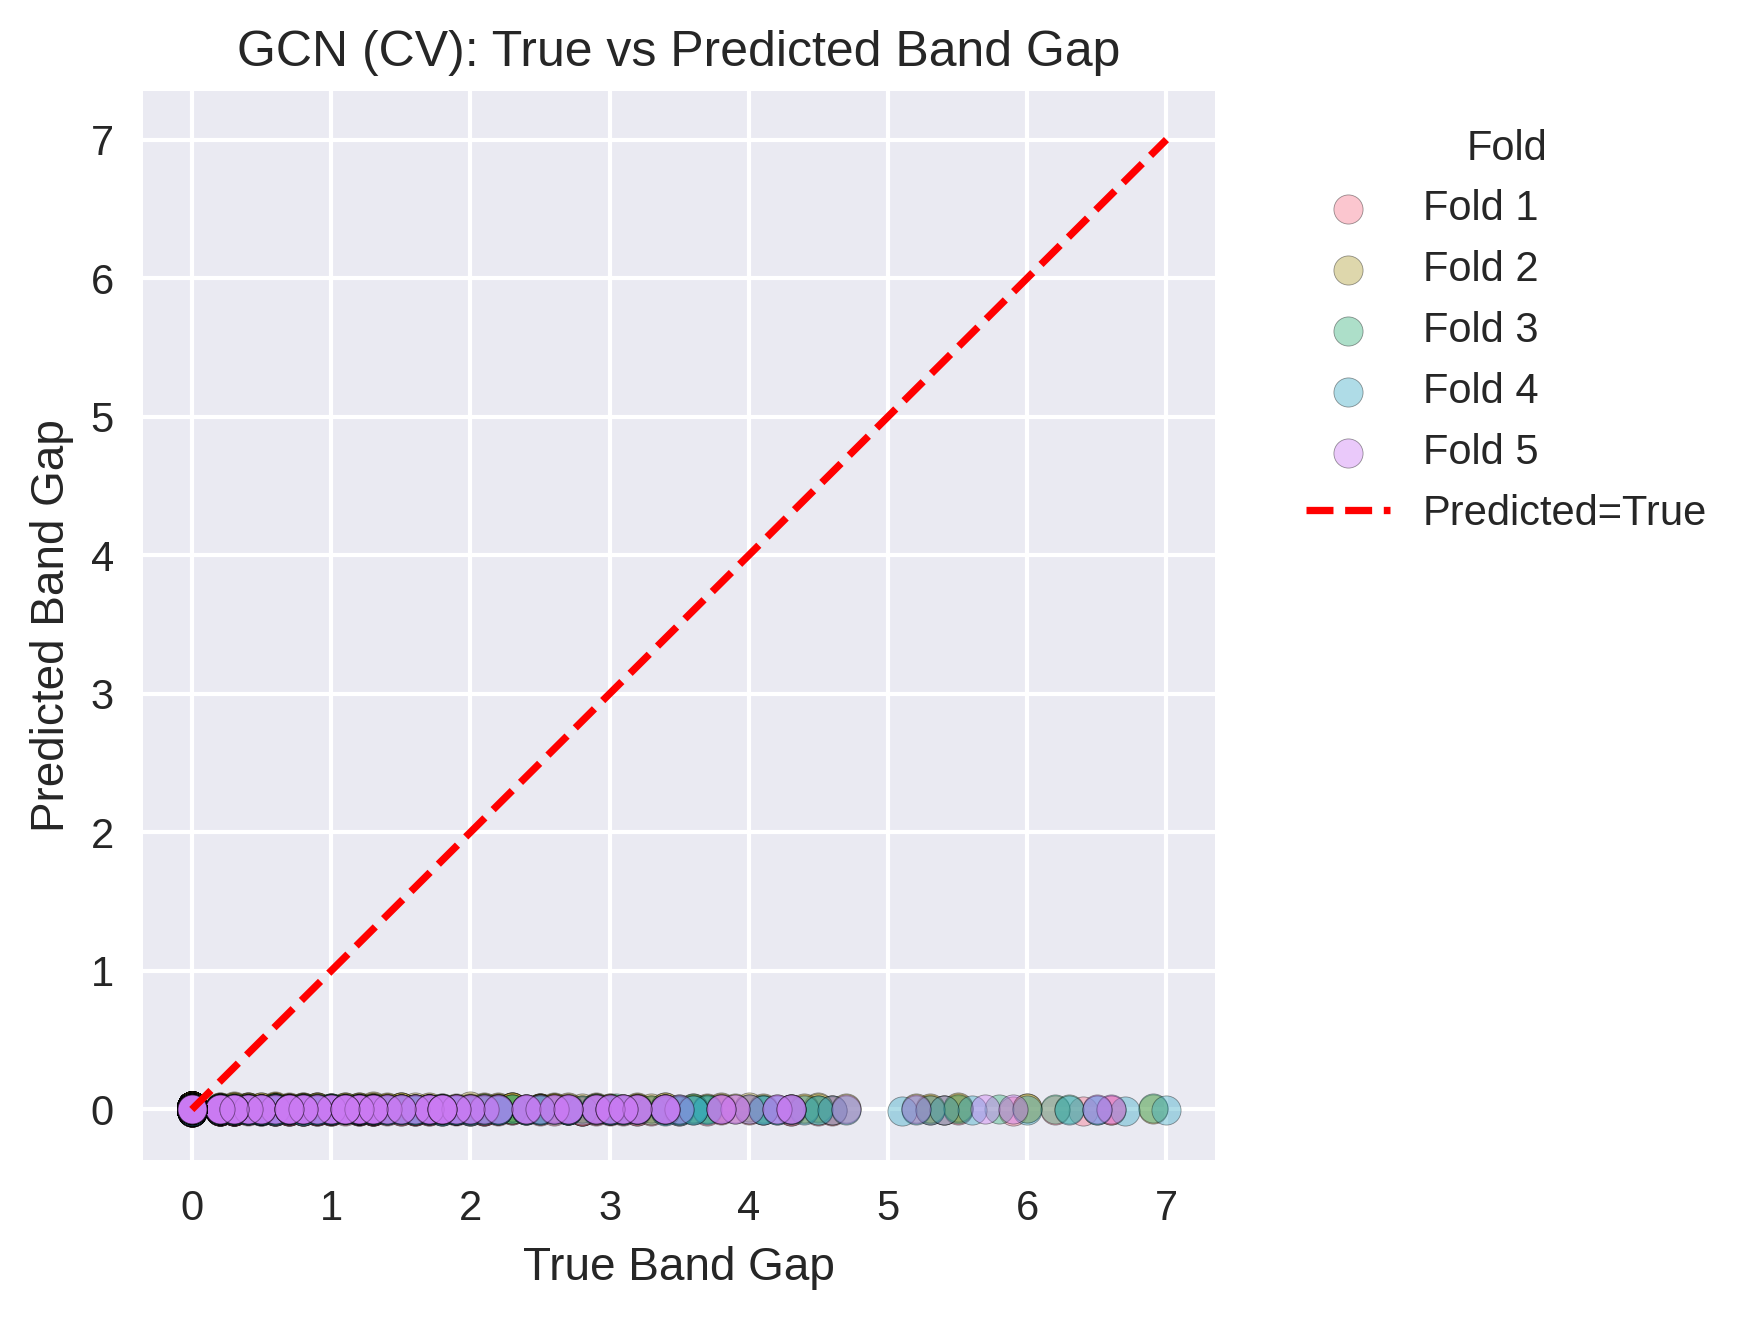

In [11]:
# --- 必要なライブラリ ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from matminer.datasets import load_dataset
from pymatgen.core import Structure

# --- データ読み込みと前処理 ---
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values

# --- pymatgen構造をPyGグラフに変換 ---
def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor([site.coords for site in structure], dtype=torch.float)
    atomic_numbers = torch.tensor([site.specie.number for site in structure], dtype=torch.long)

    edge_index = []
    for i, site_i in enumerate(structure):
        for j, site_j in enumerate(structure):
            if i != j and site_i.distance(site_j) < cutoff:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=atomic_numbers.unsqueeze(1), edge_index=edge_index, pos=positions)

# --- GCNモデル定義 ---
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# --- CV設定と保存用変数 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

y_true_all, y_pred_all, fold_ids = [], [], []
mae_list, r2_list = [], []
colors = sns.color_palette("husl", n_colors=cv.get_n_splits())

# --- クロスバリデーションループ ---
for fold, (train_idx, val_idx) in enumerate(cv.split(structures)):
    print(f"\nFold {fold+1}")

    struct_train = [structures[i] for i in train_idx]
    struct_val = [structures[i] for i in val_idx]
    y_train = targets[train_idx]
    y_val = targets[val_idx]

    train_graphs = [structure_to_graph(s) for s in struct_train]
    val_graphs = [structure_to_graph(s) for s in struct_val]

    for i, g in enumerate(train_graphs):
        g.y = torch.tensor([y_train[i]], dtype=torch.float)
    for i, g in enumerate(val_graphs):
        g.y = torch.tensor([y_val[i]], dtype=torch.float)

    train_loader = DataLoader(train_graphs, batch_size=32)
    val_loader = DataLoader(val_graphs, batch_size=32)

    model = GCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- 学習 ---
    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x.float(), batch.edge_index, batch.batch)
            loss = F.l1_loss(out.view(-1), batch.y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # --- 検証 ---
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x.float(), batch.edge_index, batch.batch)
            y_true.extend(batch.y.view(-1).cpu().numpy())
            y_pred.extend(out.view(-1).cpu().numpy())

    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    fold_ids.extend([fold] * len(y_true))

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae_list.append(mae)
    r2_list.append(r2)
    print(f"Fold {fold+1} - MAE: {mae:.3f}, R²: {r2:.3f}")

# --- 平均スコア出力 ---
print(f"\nAverage MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Average R²: {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")

# --- スキャッター図描画 ---
for fold in range(cv.get_n_splits()):
    indices = [i for i, f in enumerate(fold_ids) if f == fold]
    plt.scatter(
        np.array(y_true_all)[indices],
        np.array(y_pred_all)[indices],
        color=colors[fold],
        alpha=0.4,
        label=f"Fold {fold+1}",
        edgecolor='k',
        linewidth=0.2
    )
plt.plot(
    [min(y_true_all), max(y_true_all)],
    [min(y_true_all), max(y_true_all)],
    'r--',
    label="Predicted=True"
)
plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("GCN (CV): True vs Predicted Band Gap")
plt.legend(title="Fold", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Epoch 1, MAE: 0.1196
Epoch 2, MAE: 0.1012
Epoch 3, MAE: 0.0926
Epoch 4, MAE: 0.0875
Epoch 5, MAE: 0.0875
Epoch 6, MAE: 0.0868
Epoch 7, MAE: 0.0818
Epoch 8, MAE: 0.0816
Epoch 9, MAE: 0.0786
Epoch 10, MAE: 0.0800
Epoch 11, MAE: 0.0783
Epoch 12, MAE: 0.0773
Epoch 13, MAE: 0.0774
Epoch 14, MAE: 0.0768
Epoch 15, MAE: 0.0764
Epoch 16, MAE: 0.0749
Epoch 17, MAE: 0.0762
Epoch 18, MAE: 0.0735
Epoch 19, MAE: 0.0741
Epoch 20, MAE: 0.0734

Test MAE: 0.0752 eV


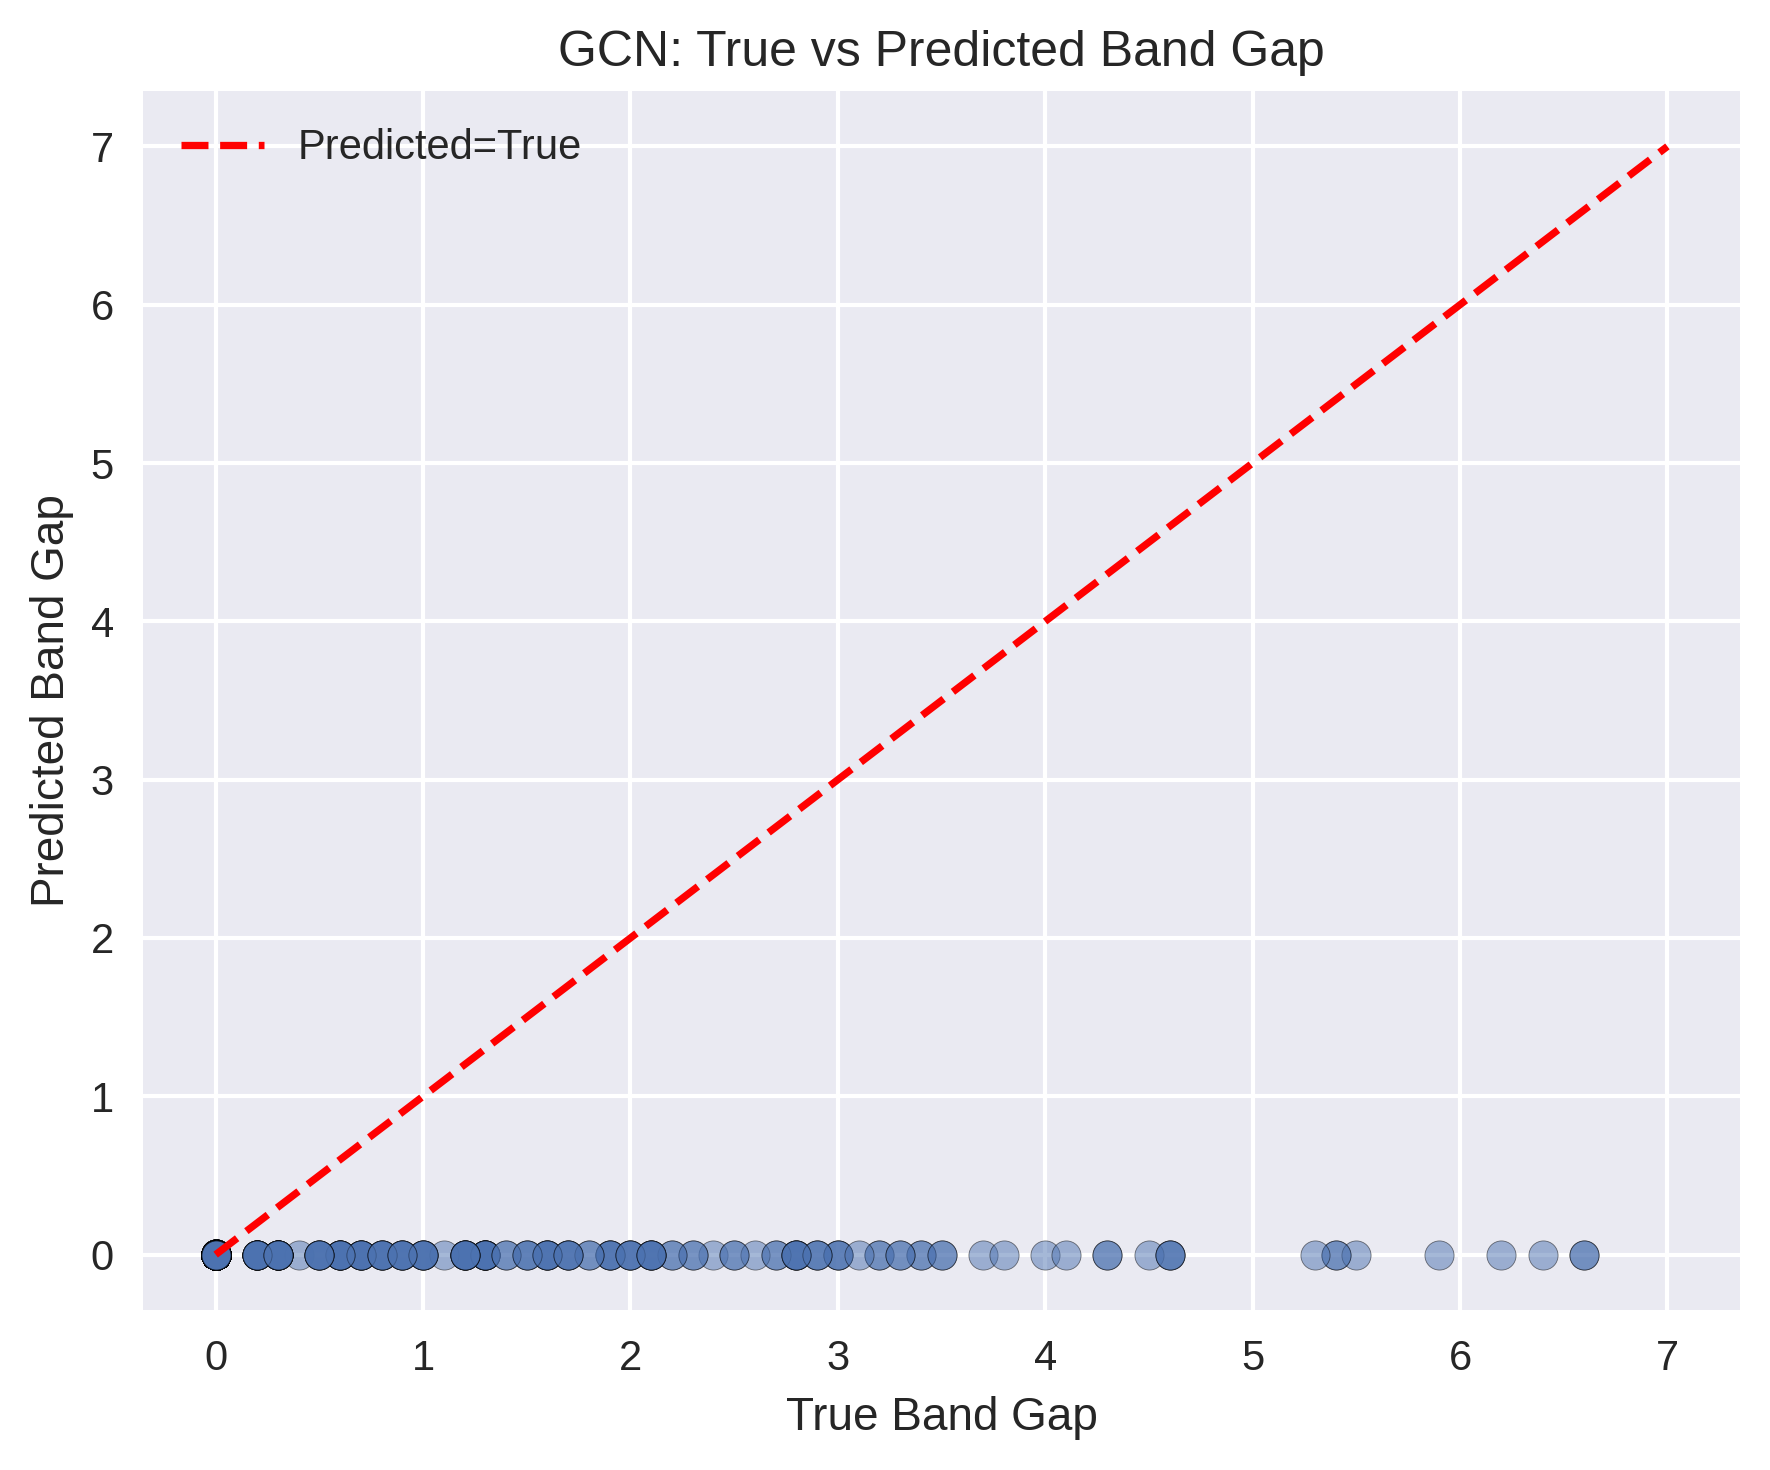

In [12]:
# 1. 必要なライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from matminer.datasets import load_dataset
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. データ準備
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values
struct_train, struct_test, y_train, y_test = train_test_split(
    structures, targets, test_size=0.2, random_state=42
)

# 3. pymatgen Structure → PyG Data 変換
def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor([site.coords for site in structure], dtype=torch.float)
    atomic_numbers = torch.tensor([site.specie.number for site in structure], dtype=torch.long)

    edge_index = []
    for i, site_i in enumerate(structure):
        for j, site_j in enumerate(structure):
            if i != j and site_i.distance(site_j) < cutoff:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(
        x=atomic_numbers.unsqueeze(1),  # (N, 1)
        edge_index=edge_index,
        pos=positions,
        z=atomic_numbers  # SchNetで使う場合の互換性確保
    )

# 4. グラフデータ作成とターゲット追加
train_graphs = [structure_to_graph(s) for s in struct_train]
test_graphs = [structure_to_graph(s) for s in struct_test]
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([y_train[i]], dtype=torch.float)
for i, g in enumerate(test_graphs):
    g.y = torch.tensor([y_test[i]], dtype=torch.float)

# 5. GCNモデル定義
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 6. 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_graphs, batch_size=32)

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = F.l1_loss(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, MAE: {total_loss / len(train_loader):.4f}")

# 7. テスト & スキャッター描画
test_loader = DataLoader(test_graphs, batch_size=32)
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        y_true.extend(batch.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().numpy())

mae = mean_absolute_error(y_true, y_pred)
print(f"\nTest MAE: {mae:.4f} eV")

# スキャッター図表示
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, edgecolor='k', linewidth=0.2)
plt.plot([0, 7], [0, 7], 'r--', label='Predicted=True')
plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("GCN: True vs Predicted Band Gap")
plt.legend()
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Frequency')

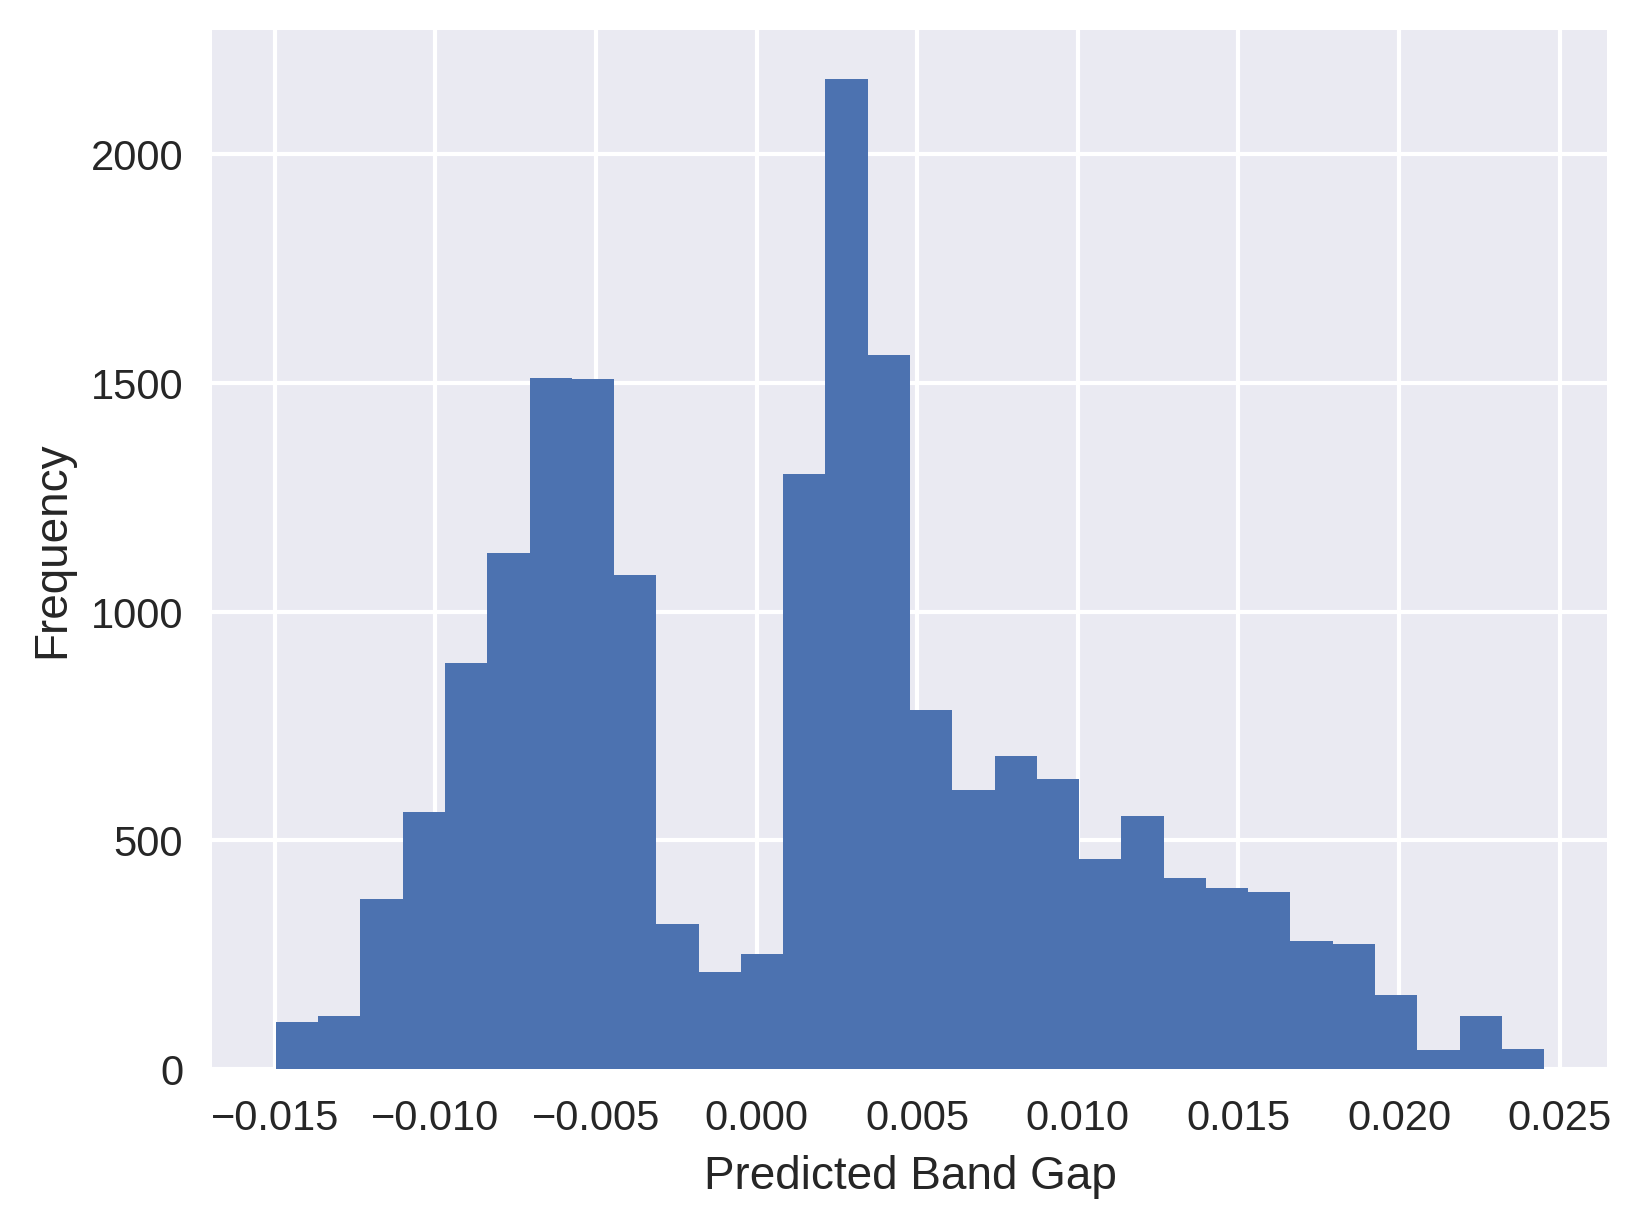

In [13]:
plt.hist(y_pred_all, bins=30)
plt.xlabel("Predicted Band Gap")
plt.ylabel("Frequency")

Epoch 1, MSE: 1.0251
Epoch 2, MSE: 0.9986
Epoch 3, MSE: 0.9986
Epoch 4, MSE: 0.9986
Epoch 5, MSE: 0.9986
Epoch 6, MSE: 0.9986
Epoch 7, MSE: 0.9986
Epoch 8, MSE: 0.9986
Epoch 9, MSE: 0.9986
Epoch 10, MSE: 0.9986
Epoch 11, MSE: 0.9986
Epoch 12, MSE: 0.9986
Epoch 13, MSE: 0.9986
Epoch 14, MSE: 0.9986
Epoch 15, MSE: 0.9986
Epoch 16, MSE: 0.9986
Epoch 17, MSE: 0.9986
Epoch 18, MSE: 0.9986
Epoch 19, MSE: 0.9986
Epoch 20, MSE: 0.9986

Test MAE: 0.1549 eV
Test R²: -0.0006


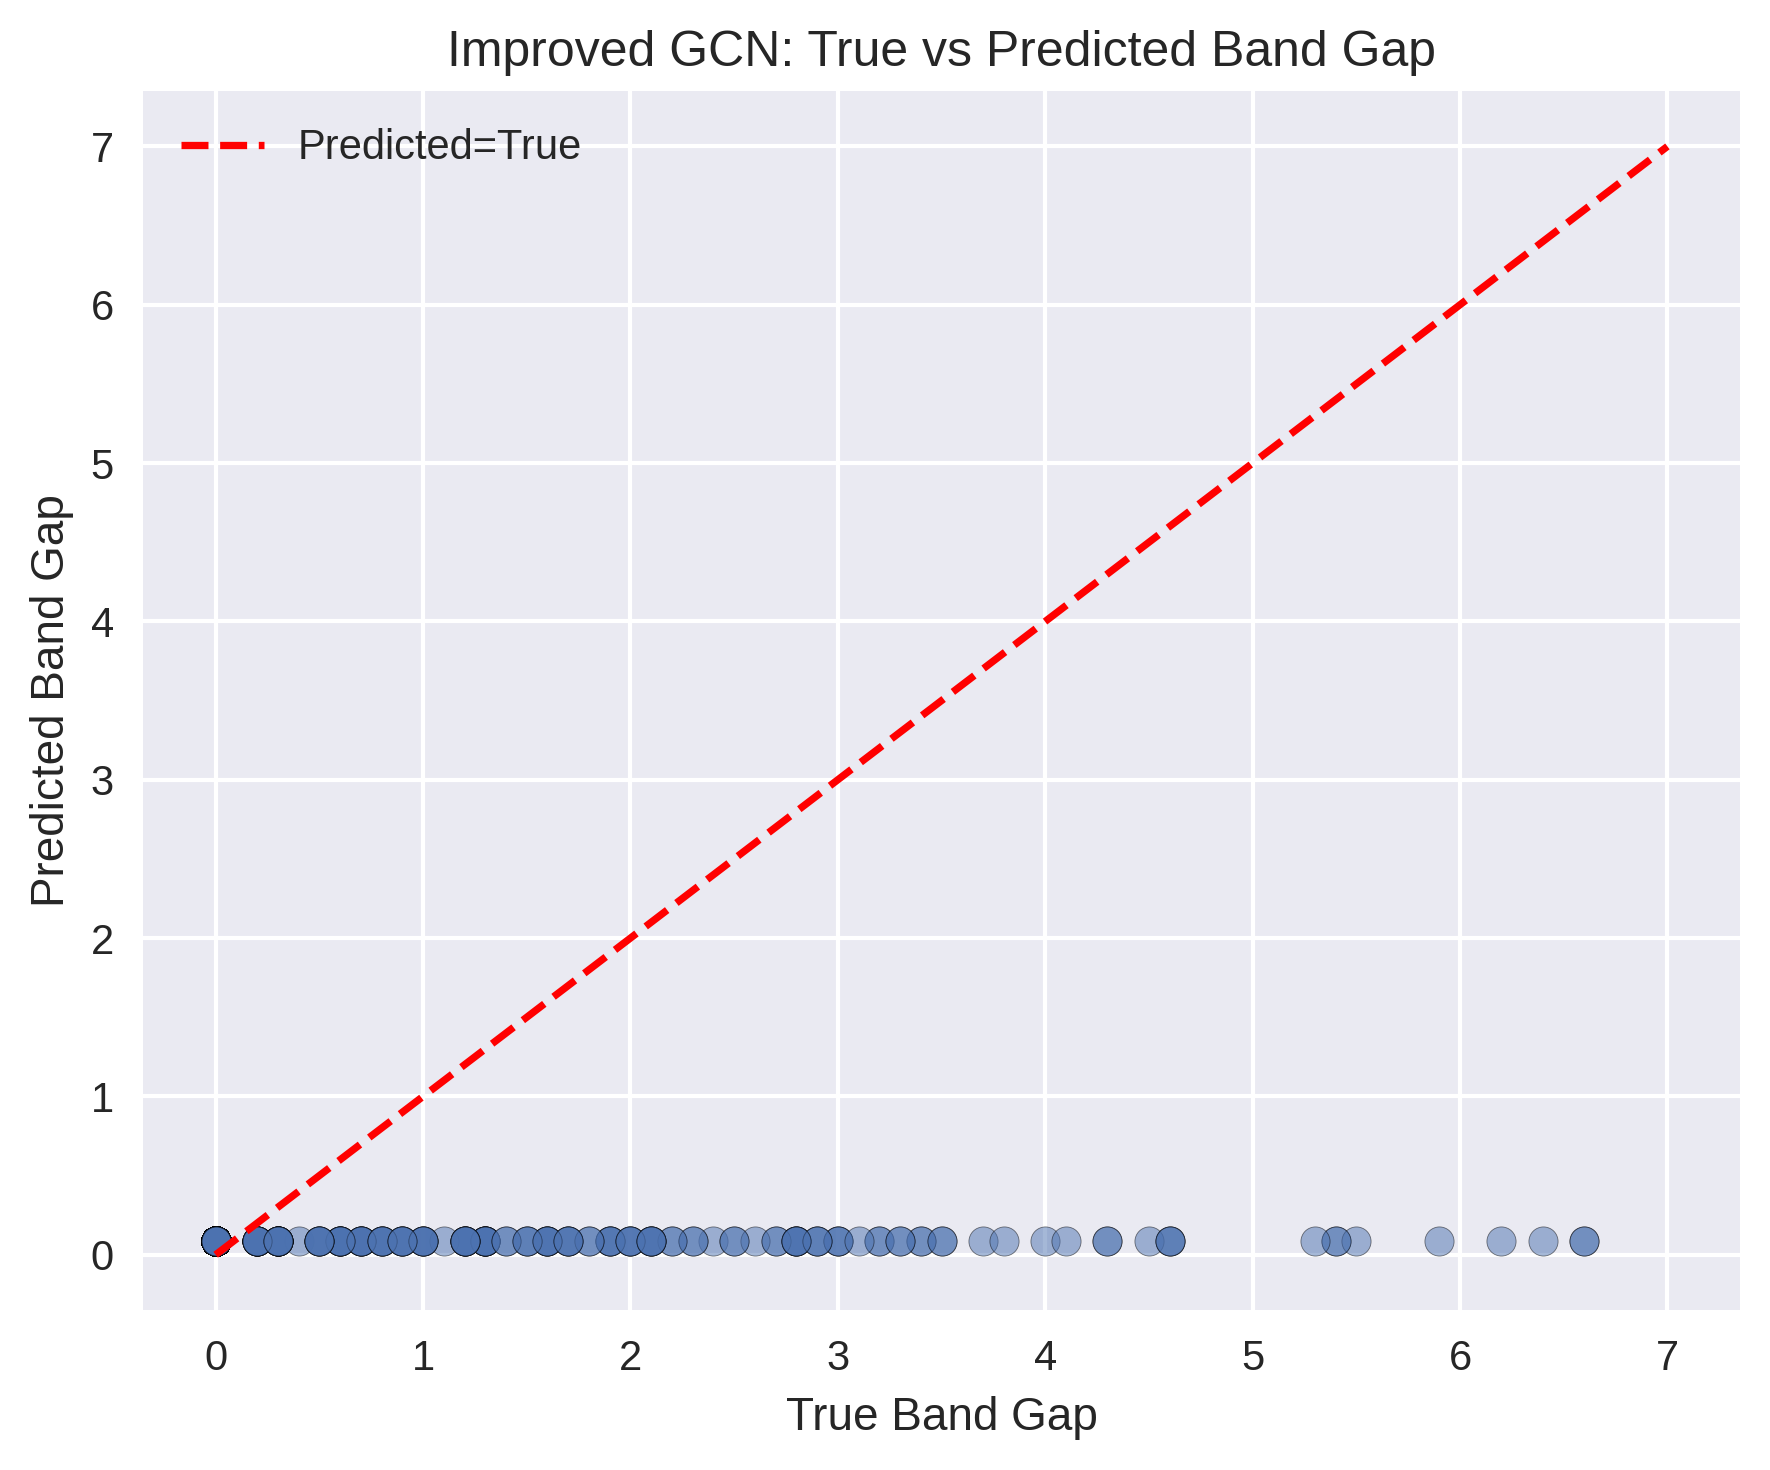

In [14]:
# 1. 必要ライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from matminer.datasets import load_dataset
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. データ読み込み
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values

# 3. 学習・テスト分割
struct_train, struct_test, y_train, y_test = train_test_split(
    structures, targets, test_size=0.2, random_state=42
)

# 4. ターゲット標準化
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

# 5. pymatgen → PyGグラフ変換
def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor([site.coords for site in structure], dtype=torch.float)
    atomic_numbers = torch.tensor([site.specie.number for site in structure], dtype=torch.long)
    edge_index = [
        [i, j] for i, site_i in enumerate(structure)
               for j, site_j in enumerate(structure)
               if i != j and site_i.distance(site_j) < cutoff
    ]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=atomic_numbers.unsqueeze(1), edge_index=edge_index, pos=positions)

# 6. グラフデータ作成とy追加
train_graphs = [structure_to_graph(s) for s in struct_train]
test_graphs = [structure_to_graph(s) for s in struct_test]
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([y_train_scaled[i]], dtype=torch.float)
for i, g in enumerate(test_graphs):
    g.y = torch.tensor([y_test_scaled[i]], dtype=torch.float)

# 7. 改良GCNモデル
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.lin = nn.Linear(128, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 8. 学習設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_loader = DataLoader(train_graphs, batch_size=32)

# 9. 学習ループ
for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = F.mse_loss(out.view(-1), batch.y.view(-1))  # ← MSE
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, MSE: {total_loss / len(train_loader):.4f}")

# 10. テスト
model.eval()
y_true, y_pred = [], []
test_loader = DataLoader(test_graphs, batch_size=32)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x.float(), batch.edge_index, batch.batch)
        y_true.extend(batch.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().numpy())

# 11. スケーラ逆変換して評価
y_true_inv = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"\nTest MAE: {mae:.4f} eV")
print(f"Test R²: {r2:.4f}")

# 12. スキャッター図
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_true_inv, y=y_pred_inv, alpha=0.5, edgecolor='k', linewidth=0.2)
plt.plot([0, 7], [0, 7], 'r--', label='Predicted=True')
plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("Improved GCN: True vs Predicted Band Gap")
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-1-4b1ed1668751>:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  positions = torch.tensor([site.coords for site in structure], dtype=torch.float)


Epoch 1, MSE: 1.1478
Epoch 2, MSE: 0.9986
Epoch 3, MSE: 0.9986
Epoch 4, MSE: 0.9986
Epoch 5, MSE: 0.9986
Epoch 6, MSE: 0.9986
Epoch 7, MSE: 0.9986
Epoch 8, MSE: 0.9986
Epoch 9, MSE: 0.9986
Epoch 10, MSE: 0.9986
Epoch 11, MSE: 0.9986
Epoch 12, MSE: 0.9986
Epoch 13, MSE: 0.9986
Epoch 14, MSE: 0.9986
Epoch 15, MSE: 0.9986
Epoch 16, MSE: 0.9986
Epoch 17, MSE: 0.9986
Epoch 18, MSE: 0.9986
Epoch 19, MSE: 0.9986
Epoch 20, MSE: 0.9986

Test MAE: 0.1549 eV
Test R²: -0.0006


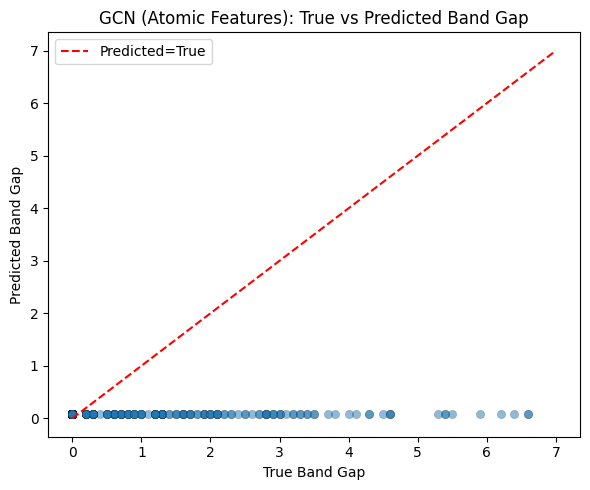

In [1]:
# 1. 必要ライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from matminer.datasets import load_dataset
from pymatgen.core import Structure
from pymatgen.core.periodic_table import Element
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. データ読み込み
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values

# 3. データ分割
struct_train, struct_test, y_train, y_test = train_test_split(
    structures, targets, test_size=0.2, random_state=42
)

# 4. ターゲットの標準化
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

# 5. 原子特徴量定義（5次元）
def get_atom_features(Z):
    el = Element.from_Z(int(Z))
    return [
        el.Z,
        el.row,
        el.group or 0,
        el.atomic_mass,
        el.X or 0.0  # electronegativity
    ]

# 6. pymatgen Structure → PyG Graph
def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor([site.coords for site in structure], dtype=torch.float)
    features = [get_atom_features(site.specie.number) for site in structure]
    x = torch.tensor(features, dtype=torch.float)

    edge_index = [
        [i, j] for i, site_i in enumerate(structure)
               for j, site_j in enumerate(structure)
               if i != j and site_i.distance(site_j) < cutoff
    ]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index, pos=positions)

# 7. グラフ作成とy追加
train_graphs = [structure_to_graph(s) for s in struct_train]
test_graphs = [structure_to_graph(s) for s in struct_test]
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([y_train_scaled[i]], dtype=torch.float)
for i, g in enumerate(test_graphs):
    g.y = torch.tensor([y_test_scaled[i]], dtype=torch.float)

# 8. モデル定義（入力: 5次元特徴量）
class GCN(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=128):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.2)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 9. 学習設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_loader = DataLoader(train_graphs, batch_size=32)

# 10. 学習ループ（MSE）
for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.mse_loss(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, MSE: {total_loss / len(train_loader):.4f}")

# 11. テスト
model.eval()
y_true, y_pred = [], []
test_loader = DataLoader(test_graphs, batch_size=32)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        y_true.extend(batch.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().numpy())

# 12. 逆変換・評価
y_true_inv = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"\nTest MAE: {mae:.4f} eV")
print(f"Test R²: {r2:.4f}")

# 13. スキャッター表示
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_true_inv, y=y_pred_inv, alpha=0.5, edgecolor='k', linewidth=0.2)
plt.plot([0, 7], [0, 7], 'r--', label='Predicted=True')
plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("GCN (Atomic Features): True vs Predicted Band Gap")
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-2-be43d5dfbadc>:43: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  el.X or 0.0
<ipython-input-2-be43d5dfbadc>:43: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  el.X or 0.0
<ipython-input-2-be43d5dfbadc>:43: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  el.X or 0.0


Epoch 1, MAE (scaled): 0.1580
Epoch 2, MAE (scaled): 0.1541
Epoch 3, MAE (scaled): 0.1539
Epoch 4, MAE (scaled): 0.1541
Epoch 5, MAE (scaled): 0.1538
Epoch 6, MAE (scaled): 0.1539
Epoch 7, MAE (scaled): 0.1539
Epoch 8, MAE (scaled): 0.1538
Epoch 9, MAE (scaled): 0.1538
Epoch 10, MAE (scaled): 0.1537
Epoch 11, MAE (scaled): 0.1540
Epoch 12, MAE (scaled): 0.1537
Epoch 13, MAE (scaled): 0.1538
Epoch 14, MAE (scaled): 0.1538
Epoch 15, MAE (scaled): 0.1539
Epoch 16, MAE (scaled): 0.1539
Epoch 17, MAE (scaled): 0.1539
Epoch 18, MAE (scaled): 0.1538
Epoch 19, MAE (scaled): 0.1538
Epoch 20, MAE (scaled): 0.1538

Test MAE: 0.0751 eV
Test R²: -0.0246


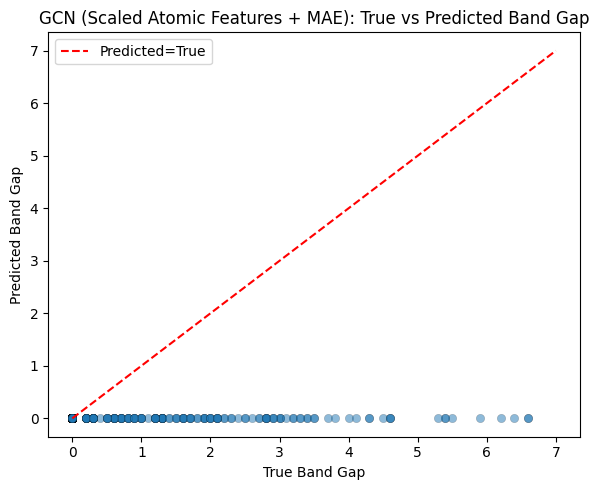

In [2]:
# 1. 必要ライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from matminer.datasets import load_dataset
from pymatgen.core import Structure
from pymatgen.core.periodic_table import Element
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. データ読み込み
df = load_dataset("castelli_perovskites")
df = df[df["gap gllbsc"].notnull()].reset_index(drop=True)

structures = df["structure"].tolist()
targets = df["gap gllbsc"].values

# 3. 学習・テスト分割
struct_train, struct_test, y_train, y_test = train_test_split(
    structures, targets, test_size=0.2, random_state=42
)

# 4. ターゲット標準化
scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1)).flatten()

# 5. 原子特徴ベクトル（Z, row, group, mass, electronegativity）
def get_atom_features(Z):
    el = Element.from_Z(int(Z))
    return [
        el.Z,
        el.row,
        el.group or 0,
        el.atomic_mass,
        el.X or 0.0
    ]

# 6. 原子特徴スケーリング（MinMax）
Z_all = list(range(1, 93))  # 1〜92番元素
feature_array = np.array([get_atom_features(Z) for Z in Z_all])
scaler_feat = MinMaxScaler()
scaled_feat_array = scaler_feat.fit_transform(feature_array)
Z_to_feat = {Z: scaled_feat_array[i] for i, Z in enumerate(Z_all)}

# 7. Structure → PyG Graph
def structure_to_graph(structure: Structure, cutoff=5.0):
    positions = torch.tensor(np.array([site.coords for site in structure]), dtype=torch.float)
    x = torch.tensor([Z_to_feat[site.specie.number] for site in structure], dtype=torch.float)

    edge_index = [
        [i, j] for i, site_i in enumerate(structure)
               for j, site_j in enumerate(structure)
               if i != j and site_i.distance(site_j) < cutoff
    ]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index, pos=positions)

# 8. グラフ作成
train_graphs = [structure_to_graph(s) for s in struct_train]
test_graphs = [structure_to_graph(s) for s in struct_test]
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([y_train_scaled[i]], dtype=torch.float)
for i, g in enumerate(test_graphs):
    g.y = torch.tensor([y_test_scaled[i]], dtype=torch.float)

# 9. モデル定義（5次元特徴）
class GCN(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=128):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.2)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 10. 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_loader = DataLoader(train_graphs, batch_size=32)

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.l1_loss(out.view(-1), batch.y.view(-1))  # ← MAE
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, MAE (scaled): {total_loss / len(train_loader):.4f}")

# 11. テスト
model.eval()
y_true, y_pred = [], []
test_loader = DataLoader(test_graphs, batch_size=32)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        y_true.extend(batch.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().numpy())

# 12. 逆変換と評価
y_true_inv = scaler_target.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
y_pred_inv = scaler_target.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"\nTest MAE: {mae:.4f} eV")
print(f"Test R²: {r2:.4f}")

# 13. スキャッター図
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_true_inv, y=y_pred_inv, alpha=0.5, edgecolor='k', linewidth=0.2)
plt.plot([0, 7], [0, 7], 'r--', label='Predicted=True')
plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("GCN (Scaled Atomic Features + MAE): True vs Predicted Band Gap")
plt.legend()
plt.tight_layout()
plt.show()
